
# Notebook to Evaluate / Compare Neural Networks

You'll need h5 and json files for a model to use this.
If you don't have those, you'll have to train a network.

Also, use this to send the csv to others after making a network, rather than using the csv from when the model's created, since that uses scaling parameters for the test subset rather than the whole dataset (they shouldn't be much different but just fyi).

Imports, open file

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout
sys.path.append(os.path.realpath("../../"))
import ptetaphi_nn
import tools
import numpy as np

# get data file path
with open("/home/cmccracken/start_tf/bbb/filepath.txt", 'r') as f:
    filename = f.read()
    
s_table = tools.open_file(filename, sort_by="tag", pt_cut=40, eta_cut=2.5)

# filter for events with 3 b tags
nt3 = s_table.nbtags==3 
events = s_table[nt3]
print(len(events))

cutoff = 10  # not many events have >10 jets
# "pad" = ensure all events have same length, cut off ends if needed
events = tools.pad(events, cutoff)

# make and train network
nn = ptetaphi_nn.PtEtaPhiNN(events, load=("models/architecture_fold_3.json", "models/weights_fold_3.h5"), njets=10, chop=0, print_summary=True)

Using TensorFlow backend.


777150 total events found
777150 events left after pt cut
777150 events left after eta cut
sorting data by tag
287645
Loading model... 
Using architecture: models/architecture_fold_3.json 
and weights: models/weights_fold_3.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 700)               21700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               350500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________

Evaluate network

100%|██████████| 57529/57529 [00:00<00:00, 83909.80it/s]


overall accuracy: 91.52 percent
ignoring 1.40 percent (808 events) of 57529 events


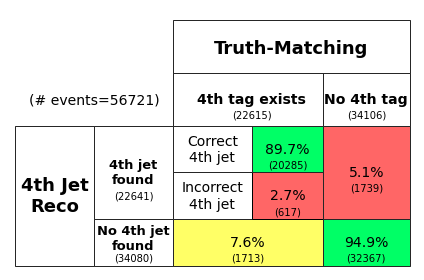

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [2]:
nn.evaluate()

Make csv with scaling parameters

100%|██████████| 287645/287645 [00:03<00:00, 78174.30it/s]


overall accuracy: 91.00 percent
ignoring 1.44 percent (4137 events) of 287645 events


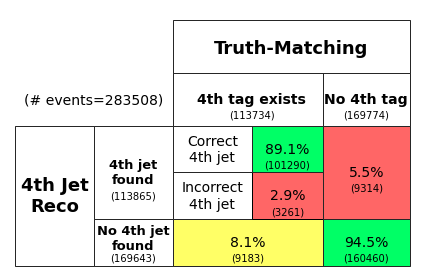

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
truth = events.truth
tag = events.tag

# give people the csv from here when trying to compare models
nn_inputs = tools.scale_nn_input(events, chop=0, save_csv="models/scaling_parameters_fold_3")

# get model outputs
scores = nn.model.predict(nn_inputs)

# convert nn scores into "selections"
select=np.argmax(scores,axis=-1)
selections = np.zeros((len(scores), len(tag[0])+1), dtype=int)
for i, s in enumerate(select):
    selections[i][s+3] = 1

# chop off the last "no selection" jet
selections = selections[:,:-1]

# evaluate again
tools.evaluate_model(truth, tag, selections)

Get network inputs and outputs for a specific event, to allow event-by-event comparison between models

In [4]:
i_to_compare = 297
print("Event",i_to_compare)
print("Inputs",nn_inputs[i_to_compare])
print("Outputs")
for j in range(len(scores[i_to_compare])):
    print(j,round(scores[i_to_compare][j],4))
print()

Event 297
Inputs [-6.3910231e-02 -6.0634297e-01 -5.5648309e-01 -3.6742315e-01
 -6.1003137e-01 -3.6417714e-01 -1.9126371e-01 -8.8892825e-02
 -3.5780847e-02 -1.5079413e-02  1.7692907e+00 -3.4227408e-02
 -5.0528115e-01  6.4502209e-01 -8.6793641e-04 -1.1336822e-03
  2.3868767e-04 -4.8667120e-05  5.8721780e-04 -1.9089503e-03
  6.9286788e-01 -1.4541835e+00 -4.7646672e-01 -7.6982397e-01
  1.2137870e-03 -1.9432867e-03 -3.3211112e-03 -1.2764952e-03
 -6.4996292e-04  2.2397183e-03]
Outputs
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.0



In [5]:
njets = 10  # number of jets in each event

# go through all events and try to find the times we picked a fake jet
n_filler_picked = 0
from tqdm import tqdm
for i in tqdm(range(len(events))):
    s = select[i]  # number of jet selected, njets-3 means no jet
    # did we make any selection?
    if s != njets - 3:
        # and if so, was it a filler jet?
        pt0 = events.resolved_lv.pt[i][s] == 0
        eta0 = events.resolved_lv.eta[i][s] == 0
        phi0 = events.resolved_lv.phi[i][s] == 0
        filler = pt0 and eta0 and phi0
        if filler:
            n_filler_picked += 1
percent = n_filler_picked/len(events)
print(n_filler_picked, 'filler events picked out of', len(events), 
     f"total events, that's {percent:.5f}%")

100%|██████████| 287645/287645 [00:03<00:00, 80754.99it/s]

486 filler events picked out of 287645 total events, that's 0.00169%
